In [1]:
import pandas as pd
import collections
import re
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Import the dataset

In [2]:
df_original = pd.read_csv('data/reduced_data.csv')

## Create a copy of the dataset
This can be run anytime to "reset" the dataset to its initial state. This is a very quick operation comparing to re reading the whole file.

In [3]:
df = df_original.copy()

# Pre processing

## Within DataFrame

### Remove rows with empty values

In [8]:
print("Len before removing empty values:", len(df))
# Remove rows with empty ingredients_tags
df = df[df['ingredients_tags'].notna()].reset_index(drop=True)
print("Len after removing empty values:", len(df))

Len before removing empty values: 795133
Len after removing empty values: 795133


### Replace '-' with spaces

In [9]:
# Replace all '-' with ' ' in ingredients_tags
df['ingredients_tags'] = df['ingredients_tags'].str.replace('-', ' ')

### Split the ingredients into a list object

In [10]:
# For each row, split the ingredients_tags into a list
df['ingredients_tags_lists'] = df['ingredients_tags'].str.split(',')
print("Type of ingredients_tags_lists:", type(df['ingredients_tags_lists'][0]))

Type of ingredients_tags_lists: <class 'list'>


Our new column type is a python list. We will remove the language tag for each ingredient

In [11]:
# Remove the language tag (e.g. 'en:' from the ingredients_tags) by keeping only the part of the string after the 3rd character
df['ingredients_tags_lists'] = df['ingredients_tags_lists'].apply(lambda x: [s[3:] for s in x])

## Creating a list of clean ingredients
The goal is to understand and visualize all of the ingredients. We will then see the number of duplicates and try to identifiy the processing we will need to do in order to get a clean list.

### Functions and imports

In [12]:
import gensim 
from gensim.models import word2vec, phrases
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short
import json

In [13]:
def export_ingredients_counts(counts_ingredients, filename):
    # Export counts_inredients to a csv file
    with open(filename, 'w') as f:
        for key, value in counts_ingredients.items():
            try:
                f.write(f"{key},{value}\n")
            except:
                continue

### Convert from dataframe to lists

In [14]:
all_ingredients = [] # List of ALL ingredients (with duplicates) with no consideration of the recipes
all_recipes_ingredients = [] # List of ALL recipes (list of ingredients for each recipe)

for i in range(len(df)): # For each recipe
    recipe = df['ingredients_tags_lists'][i] # Get the list of ingredients for the recipe
    recipe_ingredients = [] # New list of ingredients for the recipe
    
    for ing in recipe: # For each ingredient in the recipe
        ing = remove_stopwords(ing) # Remove stopwords
        all_ingredients.append(ing) # Add the ingredient to the total list of ingredients
        recipe_ingredients.append(ing) # Add the ingredient to the list of ingredients for the recipe
    
    all_recipes_ingredients.append(recipe_ingredients) # Add the list of ingredients for the recipe to the total list of recipes


### Metrics and visualizations

In [15]:
# Create a dictionary of all ingredients and their counts
counts_ingredients = collections.Counter(all_ingredients)

print("Number of ingredients (with dupes):", len(all_ingredients))
print("Number of unique ingredients:", len(set(all_ingredients)))
print("Number of recipes:", len(all_recipes_ingredients))
print("\nMost common ingredients:", counts_ingredients.most_common(10))
print("Least common ingredients:", counts_ingredients.most_common()[-10:])

Number of ingredients (with dupes): 18940526
Number of unique ingredients: 956467
Number of recipes: 795133

Most common ingredients: [('salt', 418337), ('added sugar', 397133), ('disaccharide', 359007), ('sugar', 350447), ('water', 295594), ('oil fat', 285063), ('flavouring', 284351), ('vegetable oil fat', 264698), ('vegetable', 224766), ('dairy', 223853)]
Least common ingredients: [('milchsäureester von mono und digycenden von speisefettsäuren', 1), ('kakaobatter', 1), ('volmlchpuver', 1), ('calciumsultat', 1), ('narumatrate', 1), ('natriumcaronate', 1), ('natriumciratrate', 1), ('viande hachee pur boeuf 5 m', 1), ('pourcentage matiere grasse inferieur 5 rapport collagene', 1), ('proteine viande inferieur 12 viande hachee boeuf', 1)]


####  Exporting the occurences

In [27]:
export_ingredients_counts(counts_ingredients, 'counts/ingredients_before_filtering.csv')

#### Visualizing all the ingredients

In [20]:
def plot_ingredients_length_distribution(ingredients):
    # Get the distribution of the len of each individual ingredient
    len_ingredients = [len(ing) for ing in set(ingredients)]
    print("Mean length of ingredients:", np.mean(len_ingredients))
    print("Median length of ingredients:", np.median(len_ingredients))
    print("Max length of ingredients:", np.max(len_ingredients))
    print("Min length of ingredients:", np.min(len_ingredients))
    
    # Horizontal box plot of the distribution of the len of each individual ingredient
    plt.figure(figsize=(18, 3))
    plt.boxplot(len_ingredients, vert=False)
    plt.title("Distribution of the length of each individual ingredient")
    plt.xlabel("Length of ingredient")
    plt.show()
    
def plot_recipe_number_ingredients(recipes):
    number_of_ingredients = [len(recipe) for recipe in recipes]
    print("Mean number of ingredients per recipe:", np.mean(number_of_ingredients))
    print("Median number of ingredients per recipe:", np.median(number_of_ingredients))
    print("Max number of ingredients per recipe:", np.max(number_of_ingredients))
    print("Min number of ingredients per recipe:", np.min(number_of_ingredients))
    
    plt.figure(figsize=(18, 3))
    # horizontal box plot of the distribution of the number of ingredients per recipe
    plt.boxplot(number_of_ingredients, vert=False)
    plt.title("Distribution of the number of ingredients per recipe")
    plt.xlabel("Number of ingredients")
    plt.show()
    
def plot_ingredients_occurences_distribution(occurences):
    # Plot the distribution of the occurences of ingredients using a log scale
    plt.figure(figsize=(18, 3))
    plt.hist(occurences.values(), bins=100, log=True)
    plt.title("Distribution of ingredient occurences")
    plt.xlabel("Number of occurences")
    plt.ylabel("Number of ingredients")
    plt.show()

##### Number of characters per ingredient

Mean length of ingredients: 26.298956472099928
Median length of ingredients: 21.0
Max length of ingredients: 481
Min length of ingredients: 0


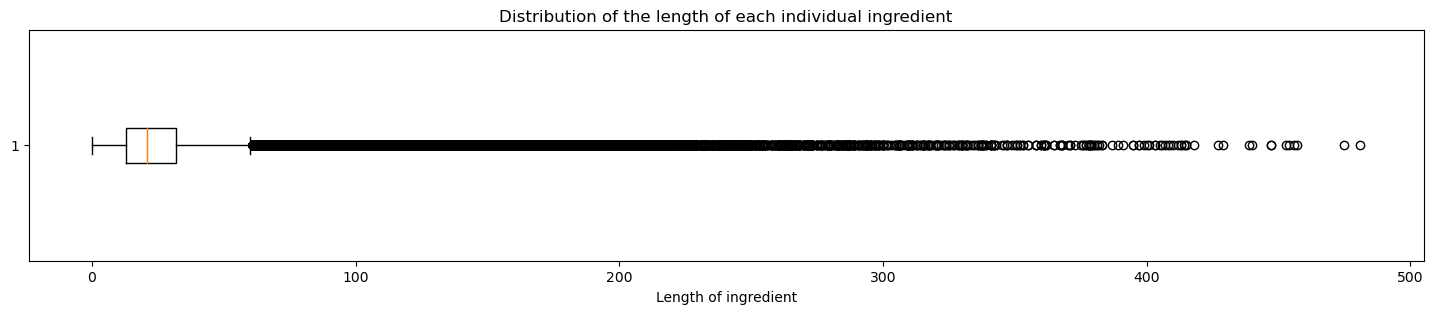

In [21]:
plot_ingredients_length_distribution(all_ingredients)

##### Number of ingredients per recipe

Mean number of ingredients per recipe: 23.82057592880688
Median number of ingredients per recipe: 19.0
Max number of ingredients per recipe: 422
Min number of ingredients per recipe: 1


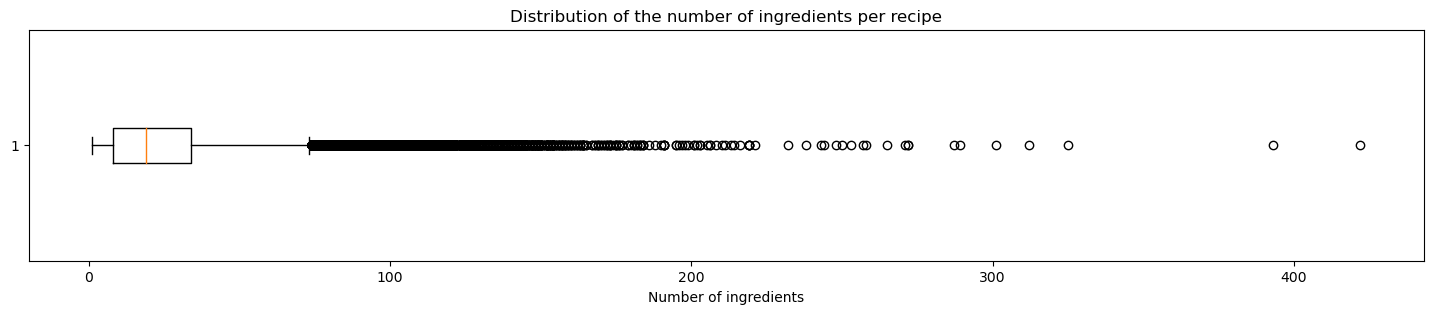

In [22]:
plot_recipe_number_ingredients(all_recipes_ingredients)

##### Ingredient occurences

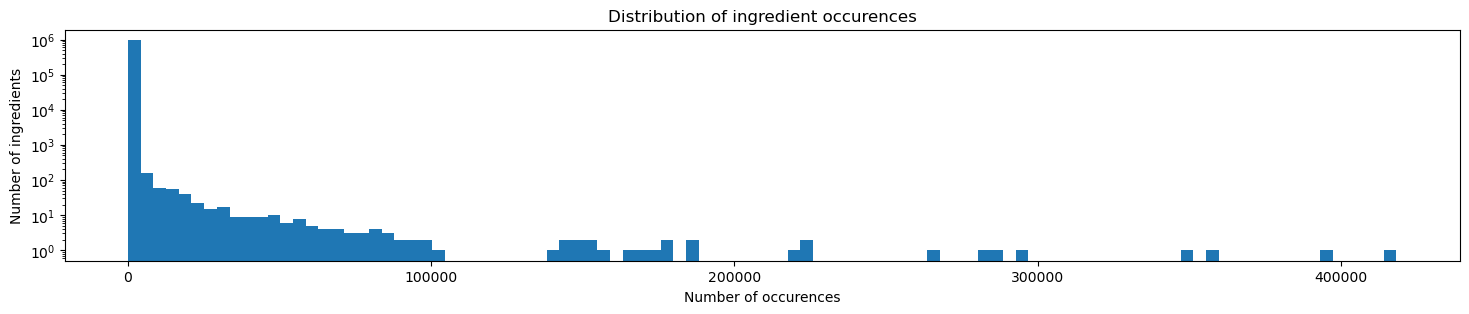

In [23]:
plot_ingredients_occurences_distribution(counts_ingredients)

### Filtering ingredients

#### Conditions / restrictions

In [24]:
clean_ingredients = []

# Ingredients that contain the following words will be removed (this list is not exhaustive and needs to be updated ; this is just a first pass)
banned_ingredients = ["disponible" , "conservé", "conserver", "consommé", "consommer", "minimum"]

for ing in all_ingredients: # For each ingredient
    # Remove ingredients that are a single character
    if len(ing) == 1:
        continue
    # Remove ingredients that contain numbers
    if re.search(r'\d', ing):
        continue
    # Remove ingredients that are in the banned_ingredients list
    banned = False
    for ban in banned_ingredients:
        if ban in ing:
            banned = True
            break
    if banned:
        continue
    # Remove ingredients that don't appear at least 200 times
    if counts_ingredients[ing] < 100:
        continue
    clean_ingredients.append(ing)

### CLEAN metrics and visualizations

In [25]:
unique_clean_ingredients = set(clean_ingredients)
print(f"Total number of clean ingredients: {len(clean_ingredients):,} (with duplicates) (before: {len(all_ingredients):,} ingredients)")
print(f"Number of unique ingredients: {len(unique_clean_ingredients):,} (before: {len(set(all_ingredients)):,} ingredients)")

Total number of clean ingredients: 14,986,764 (with duplicates) (before: 18,940,526 ingredients)
Number of unique ingredients: 3,583 (before: 956,467 ingredients)


#### Number of ingredient occurences

In [28]:
counts_clean_ingredients = collections.Counter(clean_ingredients)
export_ingredients_counts(counts_clean_ingredients, 'counts/ingredients_after_filtering.csv')

#### Translating the post-filter ingredients

##### To rerun if want to recompute

In [91]:
# # The goal is to translate to french the ingredients that are not in french
# from deep_translator import GoogleTranslator

# unique_clean_ingredients = list(unique_clean_ingredients)
# translator = GoogleTranslator(source='auto', target='fr')
# mapping = {}

# for i in range(len(unique_clean_ingredients)):
#     original = unique_clean_ingredients[i]
#     translated = translator.translate(original)
#     print(f"({i} / {len(unique_clean_ingredients)}) {original} -> {translated}")
#     mapping[original] = translated.lower()

(0 / 3585)  -> 
(1 / 3585) matiere grasse lait anhydre -> matiere grasse lait anhydre
(2 / 3585) sweet chocolate -> chocolat sucré
(3 / 3585) naturliches aroma -> Arôme naturel
(4 / 3585) parmesan romano cheese blend -> mélange de parmesan romano
(5 / 3585) silicon dioxide -> dioxyde de silicone
(6 / 3585) soybean tbhq freshness -> fraicheur du soja tbhq
(7 / 3585) meringue -> Meringue
(8 / 3585) lovage root -> racine de livèche
(9 / 3585) cultured pasteurized grade reduced fat milk -> lait de culture à teneur réduite en matières grasses pasteurisé
(10 / 3585) ingredienser -> Ingrédients
(11 / 3585) mackerel fillet -> filet de maquereau
(12 / 3585) chicken protein -> protéines de poulet
(13 / 3585) palm oil fat -> graisse d'huile de palme
(14 / 3585) vert -> verte
(15 / 3585) annatto -> rocou
(16 / 3585) sweet dairy whey -> lactosérum doux
(17 / 3585) degerminated yellow corn flour -> farine de maïs jaune dégermé
(18 / 3585) aromatiques -> aromatiques
(19 / 3585) green flageolets -> fl

###### Save ingredient translations 

In [95]:
# # Save mapping to a json file
# with open('translations/mapping.json', 'w') as f:
#     json.dump(mapping, f, indent=4)

##### Loading from file

In [29]:
# Load mapping from json file
with open('translations/mapping.json', 'r') as f:
    mapping = json.load(f)

#### Visualizing the clean ingredients

##### Number of characters of each clean ingredient

Mean length of ingredients: 14.236673178900363
Median length of ingredients: 13.0
Max length of ingredients: 66
Min length of ingredients: 0


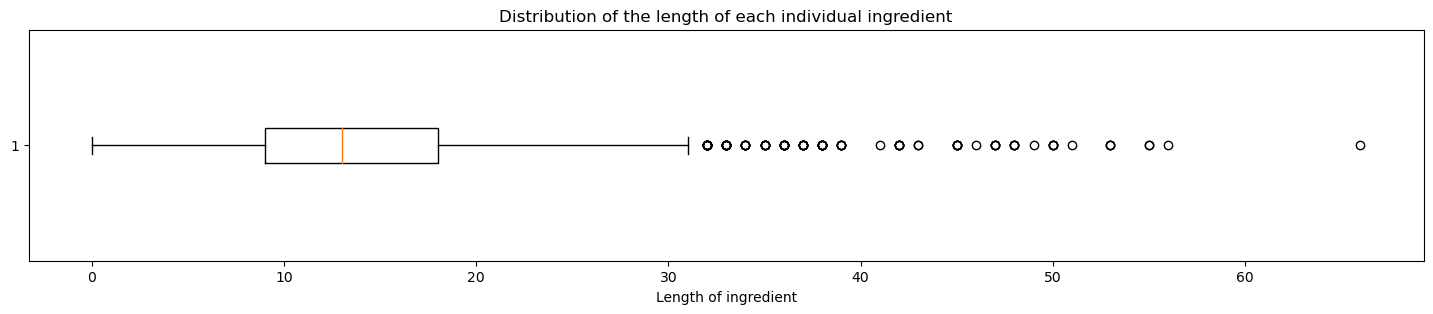

In [31]:
plot_ingredients_length_distribution(set(clean_ingredients))

## Filtering the recipes with clean ingredients

In [32]:
# Get the recipes where all of its ingredients are in the clean_ingredients list
clean_recipes_with_all_valid_ingredients = []
clean_recipes_with_all_valid_ingredients_only = []

for recipe in all_recipes_ingredients:
    valid = True
    for ing in recipe:
        if ing not in unique_clean_ingredients:
            valid = False
            break
    if valid:
        clean_recipes_with_all_valid_ingredients_only.append(recipe)
        clean_recipes_with_all_valid_ingredients.append(recipe)
    else:
        clean_recipes_with_all_valid_ingredients.append([])

In [39]:
print("Initial number of recipes:", len(all_recipes_ingredients))
print("New number of recipes:", len(clean_recipes_with_all_valid_ingredients_only))

empty_recipes = [recipe for recipe in clean_recipes_with_all_valid_ingredients if len(recipe) == 0]
print(f"--------- Checks ---------\nNumber of recipes: {len(clean_recipes_with_all_valid_ingredients)}\nNumber of empty recipes: {len(empty_recipes)}")
print(f"Number of recipes with all valid ingredients: {len(all_recipes_ingredients) - len(empty_recipes)}\n----- End of checks -----")

Initial number of recipes: 795133
New number of recipes: 142165
--------- Checks ---------
Number of recipes: 795133
Number of empty recipes: 652968
Number of recipes with all valid ingredients: 142165
----- End of checks -----


## Setting the lists to the dataframe

In [47]:
# columns_to_drop = ["ingredients_tags", "ingredients_tags_lists"]
df['clean_ingredients'] = clean_recipes_with_all_valid_ingredients
# Filter out recipes that don't have any ingredients
df = df[df['clean_ingredients'].map(len) > 0]

### Exporting the new clean dataframe

In [48]:
df.to_csv("data/clean_recipes.csv", index=False)

# Vectorizing

## Creating the model

In [50]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 4                        
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 

downsampling = 1e-2   # threshold for configuring which 
                      # higher-frequency words are randomly downsampled
            
# Initialize and train the model 
model = word2vec.Word2Vec(clean_recipes, 
                          workers=num_workers, 
                          vector_size=num_features, 
                          min_count = min_word_count, 
                          window = context,
                          sample = downsampling)

model.init_sims(replace=True)
# According to the documentation, calling init_sims(replace=True) makes the model much more memory-efficient.
# But, it also makes the model read-only, so you can't train it any further.
# If you want to train it further, call init_sims(replace=False) instead.
# However, this is going to be deprecated in the future. It is recommended to use train the model differently instead. Cf. https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

C:\Users\remS\AppData\Local\Temp\ipykernel_31372\2949049990.py:17: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


## Exploring similarities based on the wv (word vectors)

### Getting the most similar ingredients to an inputed one

In [51]:
model.wv.most_similar('olive oil')

[('sunflower oil', 0.5463489294052124),
 ('soya oil', 0.47776252031326294),
 ('sesame oil', 0.4422304034233093),
 ('rice bran oil', 0.3842189610004425),
 ('walnut oil', 0.37466681003570557),
 ('coconut oil', 0.3673168420791626),
 ('avocado oil', 0.3654404878616333),
 ('peanut oil', 0.3486948311328888),
 ('hazelnut oil', 0.3454000949859619),
 ('safflower oil', 0.3437362313270569)]

### Creating a dictionnary of search terms

In [52]:
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)] 
                 for search_term in ['salt','melon','olive', 'chocolate', 'onion']}

# Associate a color to each ingredient
similar_words

{'salt': ['iodised sea salt',
  'salz unjodiert',
  'praline',
  'salt noirmoutier',
  'salmon fillet'],
 'melon': ['lychee',
  'mirabelle plum',
  'melons confits',
  'nectarine',
  'fruit puree'],
 'olive': ['olives', 'rose petals', 'plantain', 'mate', 'dandelion'],
 'chocolate': ['pepites chocolat au lait',
  'feine milchschokolade',
  'cocoa paste',
  'cocoa liquor',
  'cocoa bean'],
 'onion': ['shallot',
  'vegetable',
  'potato',
  'carottes rapees',
  'carottes deshydratees']}

In [53]:
model.wv.most_similar(positive=['salt'])

[('iodised sea salt', 0.303181916475296),
 ('salz unjodiert', 0.27934032678604126),
 ('praline', 0.26854169368743896),
 ('salt noirmoutier', 0.24912935495376587),
 ('salmon fillet', 0.23779553174972534),
 ('lodised salt', 0.2359517365694046),
 ('yeast extract', 0.22803011536598206),
 ('contains percent salt', 0.22695501148700714),
 ('nonpareils', 0.22278770804405212),
 ('lodized salt', 0.22134321928024292)]

In [54]:
model.wv.similarity('salt', 'pepper')

-0.064352304

In [55]:
model.wv.similarity('salt', 'sugar')

-0.03819956

In [62]:
model.wv.similarity('duck', 'duck liver')

0.74734384

## Viz

In [57]:
# Create a list of 5 colors that are repeated 6 times (one for each ingredient)
cols = ['red', 'blue', 'green', 'orange', 'purple']
colors = [col for col in cols for i in range(6)]

c:\Users\remS\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\remS\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


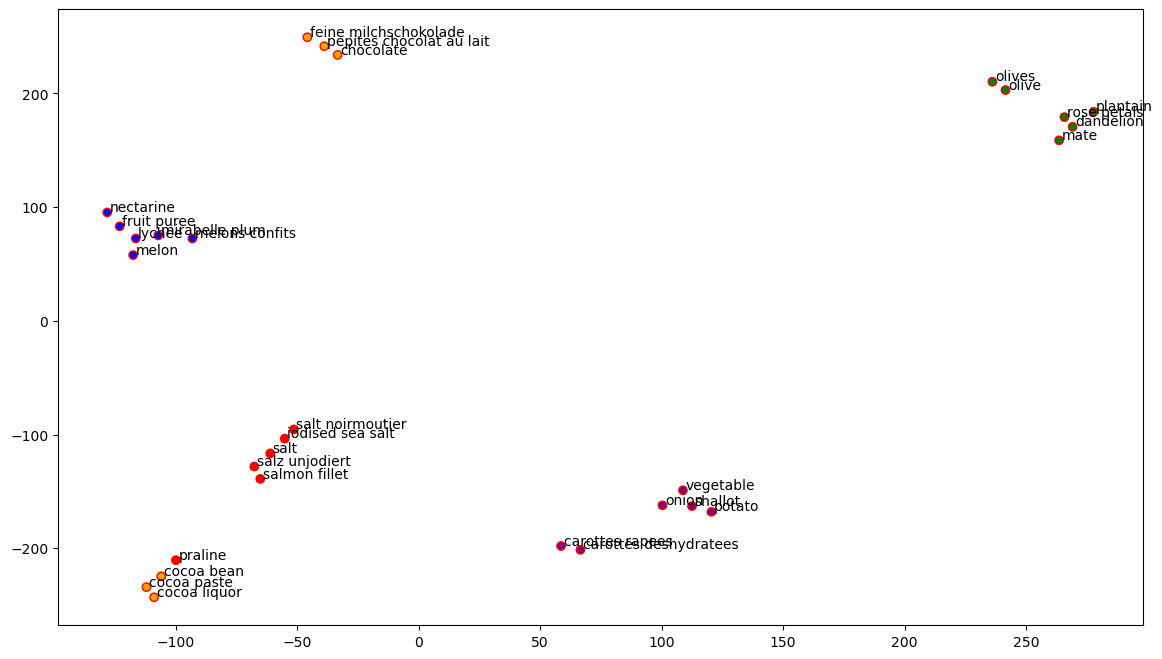

In [58]:
#visualization with Tsne
from sklearn.manifold import TSNE
import numpy as np

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')